In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from numba import jit, njit

def initial_state(N):
    """Generate an initial spin configuration with equal numbers of up and down spins."""
    state = np.ones((N, N), dtype=int)
    indices = np.arange(N*N)
    np.random.shuffle(indices)
    down_spins = indices[:N*N//2]  # Half down
    state[np.unravel_index(down_spins, (N, N))] = -1
    return state

def triangular_neighbors(i,j,N):
    """Returns the indices of the six neighbors of (i,j) in a triangular lattice."""
    neighbors = [((i-1) % N, j), ((i+1 % N), j), # top and bottom
                 (i, (j-1) % N), (i, (j+1) % N), # Left and right
                 ((i-1) % N, (j-1) % N), ((i+1) % N, (j+1) % N)] # Diagonals
    if i % 2 == 0: # even rows
        neighbors[-1] = ((i+1) % N, (j-1) % N)
    else: # odd rows
        neighbors[-2] = ((i-1) % N, (j+1) % N)
    return neighbors

def swap_spins(config):
    """Randomly swap an up spin with a down spin."""
    N = config.shape[0]
    up_indices = np.argwhere(config == 1)
    down_indices = np.argwhere(config == -1)
    
    up_choice = up_indices[np.random.randint(len(up_indices))]
    down_choice = down_indices[np.random.randint(len(down_indices))]
    
    # Swap spins
    config[up_choice[0], up_choice[1]], config[down_choice[0], down_choice[1]] = \
    config[down_choice[0], down_choice[1]], config[up_choice[0], up_choice[1]]

@njit
def calculate_energy(config, J):
    """Calculate the energy of the spin configuration."""
    energy = 0
    N = config.shape[0]
    for i in range(N):
        for j in range(N):
            S = config[i, j]
            nb = config[(i+1)%N, j] + config[i, (j+1)%N] + config[(i-1)%N, j] + config[i, (j-1)%N] # square lattice
            energy += -J*nb*S
    # magnetic_energy = -H*np.sum(config) # energy due to the magnetic field
    # return energy / 2. + magnetic_energy 
    return energy / 4.

# @jit
def mc_move(config, beta, J):
    """Perform Monte Carlo moves with the constraint of equal numbers of up and down spins."""
    N = config.shape[0]
    for _ in range(N*N):
        # Save original configuration
        original_config = np.copy(config)
        swap_spins(config)
        delta_E = calculate_energy(config, J) - calculate_energy(original_config, J)
        
        if delta_E > 0 and np.random.rand() >= np.exp(-delta_E * beta):
            # Revert the swap if the move is not energetically favorable
            config[...] = original_config

def ising_model(N=10, mc_steps=500, T=2.0, J=1.0):
    """Main simulation routine."""
    config = initial_state(N)
    beta = 1.0/T
    
    for _ in tqdm(range(mc_steps)):
        mc_move(config, beta, J)
        
    return config

def ising_model_subprocess(args):
    N, mc_steps, T, J = args
    config = initial_state(N)
    beta = 1.0/T

    for _ in tqdm(range(mc_steps)):
        mc_move(config, beta, J)

    return config

def parallel_ising_model(N=10, mc_steps=500, T=2.0, J=1.0, num_processes=4):
    pool = Pool(processes=num_processes)
    args = [(N, mc_steps // num_processes, T, J) for _ in range(num_processes)]
    results = pool.map(ising_model_subprocess, args)
    pool.close()
    pool.join()
    return  results[0]

100%|██████████| 64/64 [09:04<00:00,  8.50s/it]


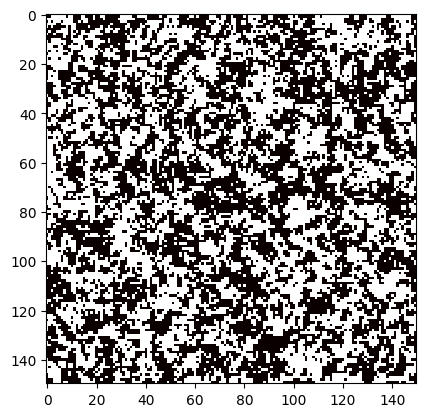

In [8]:
# Simulation Parameters
N = 150  # Lattice size
T = 0.8  # Temperature
J = 0.5 # exchange
mc_steps = 1024
num_processes = 16

config = parallel_ising_model(N, mc_steps, T, J, num_processes)

# Plot the final configuration
plt.imshow(config, cmap='hot', interpolation='nearest')
# plt.title("2D Ising Model with Equal Spins Up and Down")
plt.show()

100%|██████████| 32/32 [12:33<00:00, 23.55s/it]


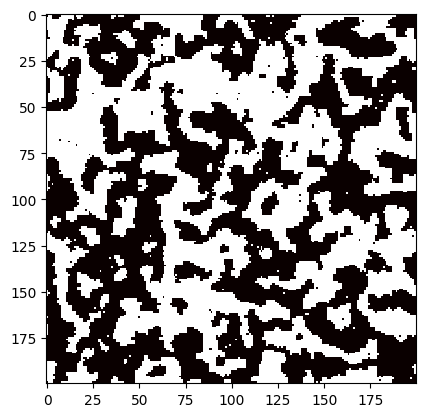

In [6]:
# Simulation Parameters
N = 200  # Lattice size
T = 0.3  # Temperature
J = 0.5 # exchange
mc_steps = 512
num_processes = 16

config = parallel_ising_model(N, mc_steps, T, J, num_processes)

# Plot the final configuration
plt.imshow(config, cmap='hot', interpolation='nearest')
# plt.title("2D Ising Model with Equal Spins Up and Down")
plt.show()

100%|██████████| 64/64 [00:09<00:00,  7.00it/s]


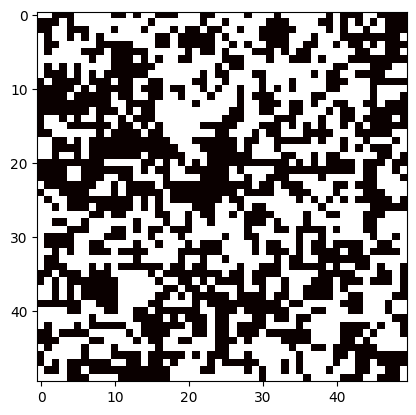

In [6]:
# Simulation Parameters
N = 200  # Lattice size
T = 3  # Temperature
J = 0.5
mc_steps = 512
num_processes = 16
config = parallel_ising_model(N, mc_steps, T, J, num_processes)

# Plot the final configuration
plt.imshow(config, cmap='hot', interpolation='nearest')
# plt.title("2D Ising Model with Equal Spins Up and Down")
plt.show()